In [1]:
import csv
import numpy as np
import pandas
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
#Reading the data
training_examples = pandas.read_csv("C:\\Users\\varamase\\Documents\\DataStreams\\M365NCA\\Data\\Features\\Training\\AllFeaturesv3.csv")
training_examples = training_examples.drop('CustomerAdd.y', axis=1)
training_examples = training_examples.drop('ym', axis=1)
training_examples_tpid = training_examples[["FinalTPID"]]
training_examples = training_examples.drop('FinalTPID', axis=1)

training_labels = training_examples[["CustomerAdd.x"]]
training_examples = training_examples.drop('CustomerAdd.x', axis=1)

#training_examples = training_examples.iloc[:,0:200]
print(len(training_examples.columns))
print (training_examples.columns)

# Adding some new % features 
training_examples['AnnuityPercentage'] = training_examples['Annuity']/(training_examples['Annuity'] + training_examples['NonAnnuity']
                                                                      + training_examples['DarkAnnuity'])
training_examples['NonAnnuityPercentage'] = training_examples['NonAnnuity']/(training_examples['Annuity'] + training_examples['NonAnnuity']
                                                                      + training_examples['DarkAnnuity'])
training_examples['DarkAnnuityPercentage'] = training_examples['DarkAnnuity']/(training_examples['Annuity'] + training_examples['NonAnnuity']
                                                                      + training_examples['DarkAnnuity'])

training_examples = training_examples.replace([np.inf, -np.inf], 0)
training_examples = training_examples.replace(np.nan, 0)
print(len(training_examples.columns))

336
Index(['O365MAU', 'O365MauTrend', 'O365MauMean', 'EXOMAU', 'EXOMAUTrend',
       'EXOMAUMean', 'ODSPMAU', 'ODSPMAUTrend', 'ODSPMAUMean', 'SfBMAU',
       ...
       'WindowsDeviceLicensingYr1', 'WindowsDeviceLicensingYr2',
       'AzureYoYChange', 'AzureMean', 'AzureYr1', 'AzureYr2',
       'dynamicsYoYChange', 'dynamicsMean', 'dynamicsYr1', 'dynamicsYr2'],
      dtype='object', length=336)
339


In [4]:
# Choose features based on intuition # 

include_features_flag = pandas.read_csv("C:\\Users\\varamase\\Documents\\DataStreams\\M365NCA\\Modeling\\Tries\\FeatureChoice.csv")
included_flag = include_features_flag['Include'] == 1
chosen_features = list((include_features_flag[included_flag])["Variable"])
print (len(chosen_features))
training_examples = training_examples[chosen_features]
print (len(training_examples.columns))

322
322


In [5]:
# Check variable correlations to each other and removing variables having correlations > 0.9 #

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

corr = training_examples.corr() 
# sns.heatmap(corr)

# Remove one of the two variables with correlations > 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = training_examples.columns[columns]
print (selected_columns)
training_examples = training_examples[selected_columns]
training_examples.to_csv("C:\\Users\\varamase\\Documents\\DataStreams\\M365NCA\\Modeling\\Tries\\SelectedCols.csv")

Index(['O365MAU', 'O365MauTrend', 'EXOMAUTrend', 'ODSPMAUTrend', 'SfBMAU',
       'SfBMAUTrend', 'TeamsMAU', 'TeamsMAUTrend', 'TeamsMAUMean',
       'DesktopPerpetual',
       ...
       'dynamicsYoYChange', 'dynamicsMean', 'dynamicsYr1', 'dynamicsYr2',
       'AnnuityPercentage', 'NonAnnuityPercentage', 'DarkAnnuityPercentage',
       'EMSE3CaoTotalEMS', 'EMSE3FuslTotalEMS', 'EMSE5CaoTotalEMS'],
      dtype='object', length=259)


In [6]:
# Different techniques for determining feature importance and final set of features to pick # 
# Conclusion - These feature selection techniques are not working very well as compared to the original techniques

from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

# Lasso Regression for feature selection #
# print (training_examples.shape)
# lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(training_examples, training_labels)
# model = SelectFromModel(lsvc, prefit=True)
# selected = model.get_support(indices = False)


# lasso_selected_features = []
# for i in range(len(training_examples.columns)):
#     column1 = training_examples.columns[i] 
#     column2 = selected[i]
#     if column2 == True:
#         lasso_selected_features.append(column1)
        
# print (lasso_selected_features)    

# training_examples = training_examples[lasso_selected_features]
# print (training_examples.shape) #98 features - reduced precision and recall

#VIF 
# import pandas as pd
# import numpy as np
# from patsy import dmatrices
# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# training_examples1 = training_examples 
# #gather features
# features = "+".join(training_examples1.columns)
# training_examples1['CustomerAdd'] = training_labels
# # get y and X dataframes based on this regression:
# y, X = dmatrices('CustomerAdd ~' + features, training_examples1, return_type='dataframe')

# # For each X, calculate VIF and save in dataframe
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# vif["features"] = X.columns

# vif_selected_columns = []
# for i in zip(vif["features"],vif["VIF Factor"]):
#     if (i[1] <= 5) :
#         vif_selected_columns.append(i[0])

# vif_selected_columns.remove('Intercept');

# training_examples = training_examples[vif_selected_columns]
# print (training_examples.shape)

# Random forests for feature importance - try seperately(lower recall and AUC) # 
# then try with Lasso (precision increases by 0.01 but lower recall and AUC) #
# Random forest + linear correlation () # 

# TODO - Need to compare performances of different params for random forests 
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = train_test_split(training_examples, training_labels, random_state=2, test_size= 0.2)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

clf = RandomForestClassifier(n_estimators=100, max_depth = 10)
clf = clf.fit(X_resampled, y_resampled)

y_predict = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

print ("Accuracy is:", accuracy_score(y_test, y_predict))
print ("Precision:", sklearn.metrics.precision_score(y_test, y_predict))
print ("Recall:", sklearn.metrics.recall_score(y_test, y_predict))


random_forest_feat_imp = clf.feature_importances_
random_forest_selected_features = []

for i in range(len(training_examples.columns)):
    feature = training_examples.columns[i]
    value = random_forest_feat_imp[i]
    random_forest_selected_features.append((feature,value))
     
random_forest_selected_features = sorted(random_forest_selected_features,key=lambda x: x[1], reverse = True)
random_forest_selected_features = random_forest_selected_features[:200]

rf_selected_features = []
for i  in random_forest_selected_features:
    rf_selected_features.append(i[0])

training_examples = training_examples[rf_selected_features]
print (training_examples.shape)

# Recursive feature elimination to reduce the set further - taking too long #
# svc = SVC(kernel="linear", C=1) # TODO - set kernel to rbf to capture non linear interactions?
# rfe  =  RFE(estimator=svc, n_features_to_select=50, step=1)
# rfe.fit(training_examples, training_labels)
# rfe.support_
# rfe.ranking_

# Could do PCA - but lose interpretability #

Accuracy is: 0.8733195449844882
Precision: 0.19909502262443438
Recall: 0.39285714285714285
(19337, 200)


In [7]:
# Check if you want to do this - Check correlations with output variable and if p value < 0.05, remove #
# Caveat - You are fitting a linear model, there could be non linear correlations you are missing out on? # 
import statsmodels.formula.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.05 # see if this should be 0.05 or 0.06
selected_columns = training_examples.columns
data_modeled, selected_columns = backwardElimination(training_examples.iloc[:,:].values, training_labels, SL, selected_columns)
print (selected_columns)
print (len(selected_columns))
training_examples = pd.DataFrame(data = data_modeled, columns = selected_columns)

Index(['WindowsCoreNonM365EnterpriseMean', 'OnPremMean', 'GeoMapping',
       'WindowsCoreNonM365E3Mean', 'O365E3add', 'IsFastTrackTenant',
       'OfficePaidAvailableUnits', 'O365E3Trend', 'o365E3Perc', 'HasEMSSku',
       'WindowsCoreNonM365E3YoYChange', 'DesktopSubscription',
       'IntuneEnabledPerc', 'o365E12Perc', 'EMSE3CaoTotalEMS',
       'IndustryMapping', 'o365E4Perc',
       'EnterpriseMobilityCoreNonM365YoYChange', 'YammerEnabledPerc',
       'HasM365SKUE3', 'AzureMean', 'ProplusUsageEnabledPerc',
       'EMSPaidAvailableUnits', 'EMSE3', 'OfficePaidTotalPerc',
       'HasWindowsSku', 'O365E4', 'Intune_configured_users', 'M365E3Mean',
       'Intune_active_users', 'O365E4Mean', 'emse3perc', 'AIPUsageEnabledPerc',
       'IntuneUsagePaidPerc', 'O365E5SecurityAnalyticsMean',
       'EMSE3FuslTotalEMS', 'O365E4Trend', 'o365e5Perc', 'HasDynamicsSku',
       'HasOfficeSKUE1', 'EMSE5EnabledUsers', 'O365E5Mean', 'IntuneClientMean',
       'WindowsPaidTotalPerc', 'Intune', 'MobIden

In [8]:
# Train - test split and over/under sampling #

# TODO - only undersample, check distribtuion of oversampling #
from sklearn.utils import resample

X_train, X_test, y_train, y_test = train_test_split(training_examples, training_labels, random_state=2, test_size= 0.2)

X_train[['CustomerAdd']] = y_train
print (X_train.shape)
print (X_test.shape)

not_add = X_train[X_train.CustomerAdd == 0]
add = X_train[X_train.CustomerAdd == 1]

# upsample minority
add_upsampled = resample(add,
                          replace=True, # sample with replacement
                          n_samples= 6000, # match number in majority class
                          random_state=27) # reproducible results

# downsample majority
not_add_downsampled = resample(not_add,
                                replace = False, # sample without replacement
                                n_samples = 10000, # match minority n
                                random_state = 27) # reproducible results


X_resampled = pd.concat([add_upsampled, not_add_downsampled])

y_resampled = X_resampled[['CustomerAdd']] 
X_resampled = X_resampled.drop('CustomerAdd', axis=1)
print (X_resampled.shape)
print (y_resampled.shape)



(15469, 53)
(3868, 52)
(16000, 52)
(16000, 1)


In [ ]:
# No need to run -  Metrics for random and majority classifier #
from sklearn.dummy import DummyClassifier
from sklearn.utils import check_X_y

a = y_test[y_test.CustomerAdd == 0]
print (a.shape)
a = y_test[y_test.CustomerAdd == 1]
print (a.shape)


# # 50% accuracy, 0.03 precision, recall # 

# # Majority # 
# # 97% accuracy, 0 precision, 0 recall #

In [11]:
# Different models # 

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

import copy

# # # Logistic Regression 
# clf = LogisticRegression(random_state=0, solver='lbfgs',)
# clf.fit(X_resampled, y_resampled)

# # SVM 
# clf = SVC(gamma='auto', kernel = 'rbf')
# clf.fit(X_resampled, y_resampled)

# # GBM
# clf = GradientBoostingClassifier(n_estimators = 100, max_depth = 3)  
# clf.fit(X_resampled, y_resampled)

# # ADA boost
# clf = AdaBoostClassifier(n_estimators = 1000)
# clf.fit(X_resampled, y_resampled)

# Neural Network - not working out 
# clf = MLPClassifier(hidden_layer_sizes=(100, 50), activation = 'relu', learning_rate = 'invscaling')
# clf.fit(X_resampled, y_resampled)

# GAM - not better than GBM
# from pygam import LogisticGAM, GammaGAM
# clf = LogisticGAM()
# clf.fit(X_resampled, y_resampled)

# XG Boost 
clf = XGBClassifier(max_depth=3,learning_rate=0.1, n_estimators=100)
clf.fit(X_resampled, y_resampled)

# Voting classifier - hard voting does not improve performance 
# clf1 = GradientBoostingClassifier(max_depth = 3)
# #clf2 = AdaBoostClassifier()
# clf3 = XGBClassifier()

# clf = VotingClassifier(estimators=[('gb', clf1), ('xgb', clf3)], voting='soft', weights = [1,1])
# clf.fit(X_resampled, y_resampled)

feature_importances = []
for i in zip(clf.feature_importances_, X_resampled.columns):
    feature_importances.append(i)
    
feature_importances = sorted(feature_importances,key=lambda x: x[0], reverse = True)
print (feature_importances)

[(0.09207762, 'HasEMSSku'), (0.0709898, 'HasM365SKUE3'), (0.066652834, 'WindowsCoreNonM365EnterpriseMean'), (0.04946919, 'WindowsCoreNonM365E3Mean'), (0.036997166, 'EMSE3CaoTotalEMS'), (0.036418725, 'GeoMapping'), (0.03257822, 'o365E4Perc'), (0.029770495, 'OnPremMean'), (0.029159874, 'IntuneEnabledPerc'), (0.027509902, 'O365E3add'), (0.027139947, 'IsFastTrackTenant'), (0.02290918, 'OfficePaidTotalPerc'), (0.022775963, 'o365E3Perc'), (0.021787185, 'O365E4'), (0.020409022, 'EMSE3'), (0.020349927, 'DesktopSubscription'), (0.018107334, 'M365E3Mean'), (0.017617684, 'HasOfficeSKUE1'), (0.015758324, 'AIPUsageEnabledPerc'), (0.015653003, 'HasWindowsSku'), (0.014431018, 'O365E5Mean'), (0.014386243, 'WindowsPaidTotalPerc'), (0.014197485, 'o365E12Perc'), (0.013907176, 'EMSPaidAvailableUnits'), (0.013541832, 'ProplusUsageEnabledPerc'), (0.013362514, 'EMSE5EnabledUsers'), (0.013137682, 'EMSE3FuslTotalEMS'), (0.012931217, 'O365E4Mean'), (0.012921142, 'OfficePaidAvailableUnits'), (0.0127198165, 'emse

Accuracy is: 0.8466907962771458
Precision: 0.19803600654664485
Recall: 0.5401785714285714
               Predicted Negative  Predicted Positive
True Negative                3154                 490
True Positive                 103                 121
3154 490 103 121


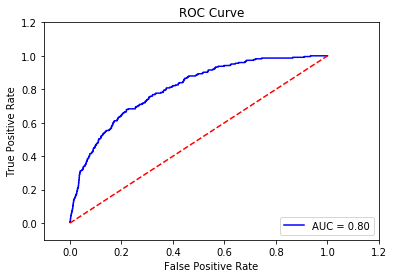

0.2898203592814371 0.22394009417482158 0.22138573912105716


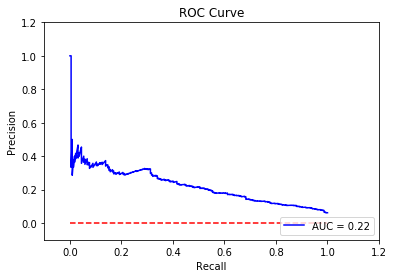

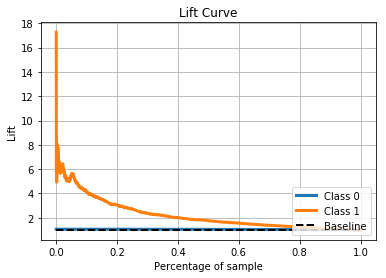

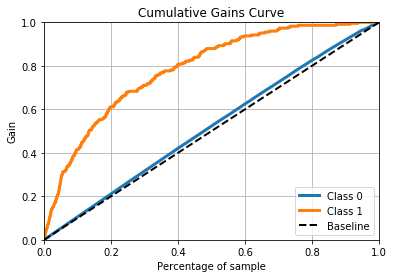

In [10]:
# Model Performance Metrics # 

y_predict = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

print ("Accuracy is:", accuracy_score(y_test, y_predict))
print ("Precision:", sklearn.metrics.precision_score(y_test, y_predict))
print ("Recall:", sklearn.metrics.recall_score(y_test, y_predict))

#Confusion Matrix
print (pandas.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Negative', 'Predicted Positive'],
    index=['True Negative', 'True Positive']
))
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
print (tn, fp, fn, tp)

#Finding AUC and plotting ROC curve for positive class
y_proba_new = []
for i in y_proba:
    y_proba_new.append(i[1])
y_proba_new = np.array(y_proba_new)

y_test_new = []

y_test_new = y_test["CustomerAdd.x"]
y_test_new = np.array(y_test_new)

# AUC curve 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_new, y_proba_new)
roc_auc = auc(false_positive_rate, true_positive_rate)


#Plotting
plt.title('ROC Curve')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Precision - Recall Curve 

precision, recall, thresholds = precision_recall_curve(y_test_new, y_proba_new)
#auc = auc(recall, precision)
f1 = f1_score(y_test, y_predict)
ap = average_precision_score(y_test_new, y_proba_new)
auc = auc(recall, precision)
print (f1, ap, auc)

plt.title('ROC Curve')
plt.plot(recall, precision, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,0],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

import scikitplot as skplt
skplt.metrics.plot_lift_curve(y_true = y_test_new, y_probas = y_proba)
skplt.metrics.plot_cumulative_gain(y_test_new, y_proba)


In [ ]:
# Isotonic regression - did not work 
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

from sklearn.isotonic import IsotonicRegression

print (y_resampled.shape)

y_resampled_new = []
y_resampled = y_resampled.values
for i in y_resampled:
    y_resampled_new.append(i[0])
y = np.array(y_resampled_new)

X = clf.predict_proba(X_resampled)
y_proba_new = []
for i in y_proba:
    y_proba_new.append(i[1])
X = np.array(y_proba_new)

iso_reg = IsotonicRegression().fit(X.flatten(), y)

#Testing
y_proba_test = clf.predict_proba(X_test)
y_proba_test_new = []
for i in y_proba_test:
    y_proba_test_new.append(i[1])
X_test_new = np.array(y_proba_test_new)

y_predict = iso_reg.predict(X_test_new)
print (y_predict)



import numpy
y_predict = numpy.nan_to_num(y_predict)

# Precision - Recall Curve 
y_test_new = []
for i in y_predict:
    print (i)
    if (i > 0.50):
        y_test_new.append(1)
    else:
        y_test_new.append(0)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_new, y_predict)

roc_auc = auc(false_positive_rate, true_positive_rate)
precision, recall, thresholds = precision_recall_curve(y_test_new, y_predict)
auc1= auc(recall, precision)


plt.title('ROC Curve')
plt.plot(recall, precision, 'b',
label='AUC = %0.2f'% auc1)
plt.legend(loc='lower right')
plt.plot([0,1],[0,0],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()






In [159]:
import pickle

filename = 'C:\\Users\\varamase\\Documents\\DataStreams\\M365NCA\\Modeling\\Tries\\Model_best3.sav'
pickle.dump(clf, open(filename, 'wb')) #6000, 10000, voting classifier 

In [351]:
# TODO - 5 fold cross validation with top features #

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc

clf1 = GradientBoostingClassifier(max_depth = 3)
clf3 = XGBClassifier()

model = VotingClassifier(estimators=[('gb', clf1), ('xgb', clf3)], voting='soft', weights = [1,1])

accuracy = []
precision = []
recall = []
accuracy = []
roc = []
kf = KFold(n_splits=5)


training_examples_new = np.array(training_examples)
training_labels_new = np.array(training_labels)

count = 1
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for train_index,test_index in kf.split(training_examples_new):
    X_train, X_test = training_examples_new[train_index], training_examples_new[test_index]
    y_train, y_test = training_labels_new[train_index], training_labels_new[test_index]
    
    #Sampling
    X_train[['CustomerAdd']] = y_train
    not_add = X_train[CustomerAdd == 0]
    add = X_train[CustomerAdd == 1]

    # upsample minority
    add_upsampled = resample(add,
                              replace=True, # sample with replacement
                              n_samples= 6000, # match number in majority class
                              random_state=27) # reproducible results

    # downsample majority
    not_add_downsampled = resample(not_add,
                                    replace = False, # sample without replacement
                                    n_samples = 10000, # match minority n
                                    random_state = 27) # reproducible results


    X_resampled = pd.concat([add_upsampled, not_add_downsampled])

    y_resampled = X_resampled[['CustomerAdd']] 
    X_resampled = X_resampled.drop('CustomerAdd', axis=1)
    
    model.fit(X_resampled, y_resampled)
    y_predict = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    accuracy.append(accuracy_score(y_test, y_predict))
    print ("Precision:", sklearn.metrics.precision_score(y_test, y_predict))
    precision.append(sklearn.metrics.precision_score(y_test, y_predict))
    print ("Recall:", sklearn.metrics.recall_score(y_test, y_predict))
    recall.append(sklearn.metrics.recall_score(y_test, y_predict))
    print (accuracy_score(y_test, y_predict))
    print (pandas.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Negative', 'Predicted Positive'],
    index=['True Negative', 'True Positive']
    ))
    
    y_proba_new = []
    for i in y_proba:
        y_proba_new.append(i[1])
    y_proba_new = np.array(y_proba_new)
    
    y_test_new = []
    for i in y_test:
        y_test_new.append(i[0])
    y_test_new = np.array(y_test_new)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_new, y_proba_new)
    tprs.append(interp(mean_fpr, false_positive_rate, true_positive_rate))
    tprs[-1][0] = 0.0
    roc_auc = auc(false_positive_rate, true_positive_rate)
    aucs.append(roc_auc)

    plt.plot(false_positive_rate, true_positive_rate, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (count, roc_auc))
    print ("ROC:", roc_auc)
    roc.append(roc_auc)
    count += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Random', alpha=.8)

print ("Accuracy is:", accuracy)
print ("Mean accuracy is:", np.mean(np.array(accuracy)))
print ("Mean precision is:", np.mean(np.array(precision)))
print ("Mean recall is:", np.mean(np.array(recall)))
print ("Mean auc is:", np.mean(np.array(roc)))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid()
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices